# Imports

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy.stats import entropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Utils

In [ ]:
def plot_boxplot(df, column_name):
    df[column_name].plot(kind='box')

# Reproducibility

In [107]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# EDA

## Basic Info

In [108]:
train_raw_df = pd.read_csv('train.csv')

survival 	Survival 	0 = No, 1 = Yes ============> Se sobreviveu ou não

pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd ============> Tipo de ticket de ingresso

sex 	Sex 	============> Sexo

Age 	Age in years 	============> Idade

sibsp 	# of siblings / spouses aboard the Titanic 	============> Número de irmãos ou esposas abordo

parch 	# of parents / children aboard the Titanic 	============> Número de pais ou crianças abordo

ticket 	Ticket number 	============> Número do ticket

fare 	Passenger fare 	============> Basicamente o que foi pago na passagem. Porém, não é individual e sim referente ao "grupo" de pessoas que a comprou

cabin 	Cabin number ============> Número da cabine 	

embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton ============> Porto onde embarcaram

In [109]:
train_raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Aparentemente apenas idade, o número da Cabine e o Ponto de embarque te valores nulos

Idade tem até uma quantidade razoável, mas há de se pensar o que será feito com essa variável <br>
Cabine tem muitos não nulos então provavelmente vai ser só jogar fora mesmo <br>
Embarked só tem 2 nulos então jogarei fora as 2 linhas que possuem nulo

In [110]:
train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Nenhum dado parece estar errado pela distribuição dos dados.

O mais discrepante parece o Fare mas talvez até seja razoável pensar numa Fare tão alta

In [111]:
train_raw_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Columns Counts

Como Sex evidentemente é binário, será necessário apenas binarizar esses valores em 0 ou 1

In [112]:
train_raw_df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

Coluna inútil

In [113]:
train_raw_df['Ticket'].value_counts()

Ticket
1601         7
CA. 2343     7
347082       7
3101295      6
CA 2144      6
            ..
A/5 21172    1
349219       1
234818       1
345364       1
A/5 2466     1
Name: count, Length: 681, dtype: int64

Agora que essa aqui vai ser jogada fora mesmo

In [114]:
train_raw_df['Cabin'].value_counts()

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Precisará de um One Hot Encoding

In [115]:
train_raw_df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

## Outliers Analysis

Tem outliers, mas honestamente parecem bem normais então não vejo muito motivo pra tratá-los

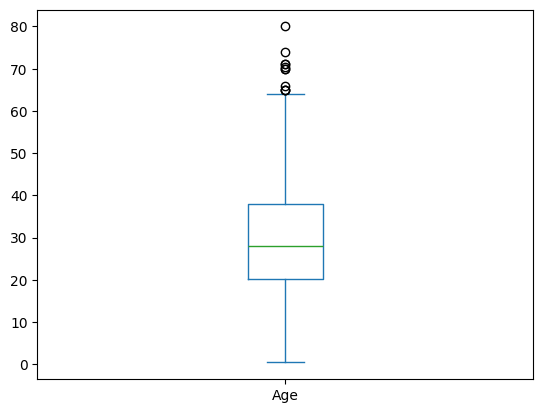

In [116]:
plot_boxplot(train_raw_df, 'Age')

Fare tem um bocadinho de outliers, possivelmente será preciso tratá-los

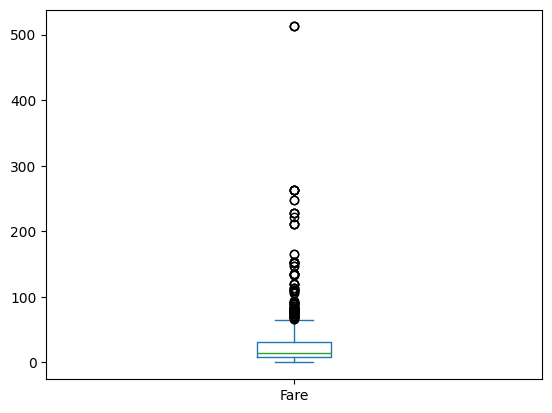

In [117]:
plot_boxplot(train_raw_df, 'Fare')

Tanto o SibSp como o Parch eu não vejo motivo pra remover outliers não

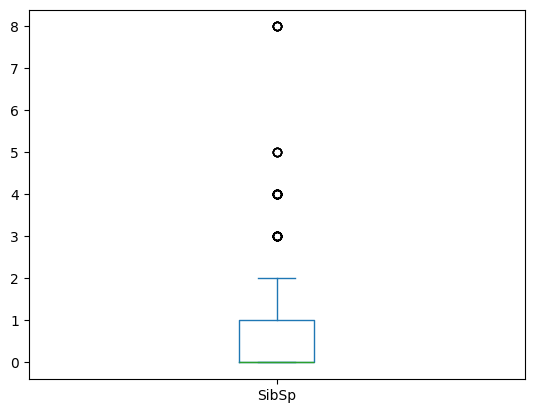

In [118]:
plot_boxplot(train_raw_df, 'SibSp')

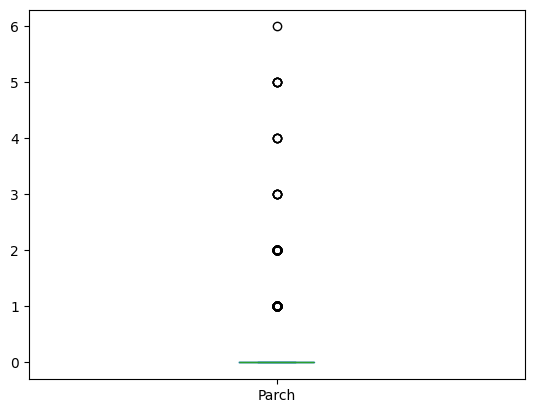

In [119]:
plot_boxplot(train_raw_df, 'Parch')

In [120]:
train_raw_df['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

## Correlation

A correlação entre Fare e PClass está muito (modularmente) alta. Nesse notebook, vou tirar o Fare e deixar o Pclass, assim não preciso nem me preocupar com a questão dos outliers

Além disso, a correlação entre SibSp e Parch também tem uma certa relevância. Acho que talvez valha a pena explorar a possibilidade de juntar esses 2 atributos ema algum momento

In [121]:
train_raw_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


## Unbalance

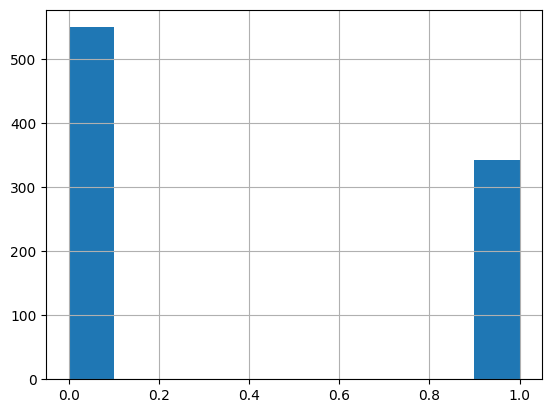

In [ ]:
train_raw_df['Survived'].hist()

In [123]:
pk = train_raw_df['Survived'].value_counts(normalize=True)
shannon_entropy = entropy(pk, base=2)
max_entropy = np.log2(2)
normalized_entropy = shannon_entropy / max_entropy

Como a entropia está bem próximo de 1, não é necessário usar técnicas de balanceamento

In [124]:
normalized_entropy

np.float64(0.9607079018756469)

## 

# Preprocess

## Drop Columns

In [125]:
train_df = train_raw_df.copy()
test_df = pd.read_csv('test.csv')

In [126]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As colunas passengerId, Name, Ticket e Cabin serão excluídas por serem irrelevantes

A coluna Fare vai ser excluída por ser muito correlacionada com PClass

In [127]:
train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare'], inplace=True)
test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare'], inplace=True)

## Drop NA Values

In [128]:
train_df.dropna(subset=['Embarked'], inplace=True)
test_df.dropna(subset=['Embarked'], inplace=True)

## Split dataset

In [129]:
X, y = train_df.drop(columns=['Survived']), train_df['Survived']

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Filling NA values

In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    711 non-null    int64  
 1   Sex       711 non-null    object 
 2   Age       571 non-null    float64
 3   SibSp     711 non-null    int64  
 4   Parch     711 non-null    int64  
 5   Embarked  711 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 38.9+ KB


In [132]:
train_df['Age'].mean()

np.float64(29.64209269662921)

In [133]:
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)
X_val['Age'].fillna(X_train['Age'].mean(), inplace=True)
test_df['Age'].fillna(X_train['Age'].mean(), inplace=True)

/tmp/ipykernel_81647/59074145.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)
/tmp/ipykernel_81647/59074145.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    711 non-null    int64  
 1   Sex       711 non-null    object 
 2   Age       711 non-null    float64
 3   SibSp     711 non-null    int64  
 4   Parch     711 non-null    int64  
 5   Embarked  711 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 38.9+ KB


In [135]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 160 to 637
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    178 non-null    int64  
 1   Sex       178 non-null    object 
 2   Age       178 non-null    float64
 3   SibSp     178 non-null    int64  
 4   Parch     178 non-null    int64  
 5   Embarked  178 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.7+ KB


## OHE and Binary

Vou transformar tanto Pclass como Embarked em OHE

In [136]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
621,1,male,42.000000,1,0,S
481,2,male,29.747951,0,0,S
527,1,male,29.747951,0,0,S
435,1,female,14.000000,1,2,S
797,3,female,31.000000,0,0,S


In [137]:
X_train = pd.get_dummies(data = X_train, columns=['Pclass', 'Embarked'])
X_val = pd.get_dummies(data = X_val, columns=['Pclass', 'Embarked'])
test_df = pd.get_dummies(data = test_df, columns=['Pclass', 'Embarked'])

In [138]:
X_train.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
621,male,42.000000,1,0,True,False,False,False,False,True
481,male,29.747951,0,0,False,True,False,False,False,True
527,male,29.747951,0,0,True,False,False,False,False,True
435,female,14.000000,1,2,True,False,False,False,False,True
797,female,31.000000,0,0,False,False,True,False,False,True


In [139]:
X_train['Sex'] = X_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
X_val['Sex'] = X_val['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [140]:
X_train.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
621,1,42.000000,1,0,True,False,False,False,False,True
481,1,29.747951,0,0,False,True,False,False,False,True
527,1,29.747951,0,0,True,False,False,False,False,True
435,0,14.000000,1,2,True,False,False,False,False,True
797,0,31.000000,0,0,False,False,True,False,False,True


## Normalization

In [141]:
scaler = StandardScaler()

In [142]:
scaled_age = scaler.fit_transform(X_train['Age'].values.reshape(-1, 1))
X_train['Age'] = scaled_age

scaled_age = scaler.transform(X_val['Age'].values.reshape(-1, 1))
X_val['Age'] = scaled_age

scaled_age = scaler.transform(test_df['Age'].values.reshape(-1, 1))
test_df['Age'] = scaled_age

In [143]:
# scaled_SibSp = scaler.fit_transform(X_train['SibSp'].values.reshape(-1, 1))
# X_train['SibSp'] = scaled_SibSp

# scaled_SibSp = scaler.transform(X_val['SibSp'].values.reshape(-1, 1))
# X_val['SibSp'] = scaled_SibSp

# scaled_SibSp = scaler.transform(test_df['SibSp'].values.reshape(-1, 1))
# test_df['SibSp'] = scaled_age

In [144]:
# scaled_Parch = scaler.fit_transform(X_train['Parch'].values.reshape(-1, 1))
# X_train['Parch'] = scaled_Parch

# scaled_Parch = scaler.transform(X_val['Parch'].values.reshape(-1, 1))
# X_val['Parch'] = scaled_Parch

# scaled_Parch = scaler.transform(test_df['Parch'].values.reshape(-1, 1))
# test_df['Parch'] = scaled_age

In [145]:
X_train.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
621,1,9.428390e-01,1,0,True,False,False,False,False,True
481,1,-2.733940e-16,0,0,False,True,False,False,False,True
527,1,-2.733940e-16,0,0,True,False,False,False,False,True
435,0,-1.211861e+00,1,2,True,False,False,False,False,True
797,0,9.634965e-02,0,0,False,False,True,False,False,True


In [146]:
X_val.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
160,1,1.096746,0,1,False,False,True,False,False,True
126,1,0.000000,0,0,False,False,True,False,True,False
428,1,0.000000,0,0,False,False,True,False,True,False
422,1,-0.057558,0,0,False,False,True,False,False,True
565,1,-0.442325,2,0,False,False,True,False,False,True


# Deep Learning

In [147]:
input_dim = X_train.shape[1]

# Construir o modelo
model = Sequential([
    # Camada de entrada e primeira camada oculta (mais larga)
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(input_dim,)),
    Dropout(0.4),

    Dense(96, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),

    # Segunda camada oculta (mais larga)
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    # Terceira camada oculta (mais profunda)
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    # Camada de saída
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Loss function para classificação binária
              metrics=['accuracy'])

# Visualizar a arquitetura do modelo
model.summary()

/home/victor/anaconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,753 (88.88 KB)

 Trainable params: 22,433 (87.63 KB)

 Non-trainable params: 320 (1.25 KB)

## Train Data

In [148]:
epochs = 100
batch_size = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping] # Mostra o progresso do treinamento
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5288 - loss: 1.0983 - val_accuracy: 0.6461 - val_loss: 0.9176
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5626 - loss: 1.0360 - val_accuracy: 0.6124 - val_loss: 0.8957
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5781 - loss: 1.0145 - val_accuracy: 0.6180 - val_loss: 0.8821
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6371 - loss: 0.9295 - val_accuracy: 0.6348 - val_loss: 0.8629
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6639 - loss: 0.8947 - val_accuracy: 0.7191 - val_loss: 0.8458
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 0.9055 - val_accuracy: 0.7584 - val_loss: 0.8331
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7018 - loss: 0.8547 - val_accuracy: 0.7753 - val_loss: 0.8229
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.8187 - val_accuracy: 0.7865 - 

## Mean Error 

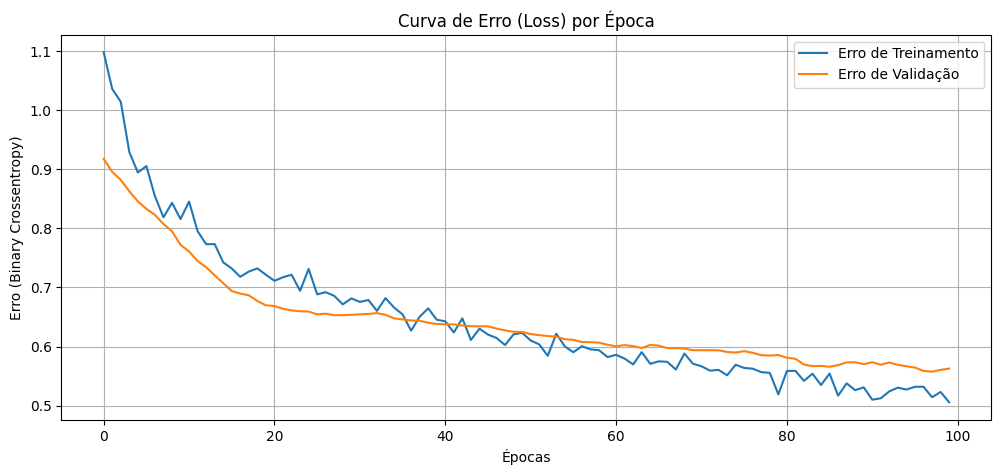

In [149]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Erro de Treinamento')
plt.plot(history.history['val_loss'], label='Erro de Validação')
plt.title('Curva de Erro (Loss) por Época')
plt.xlabel('Épocas')
plt.ylabel('Erro (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


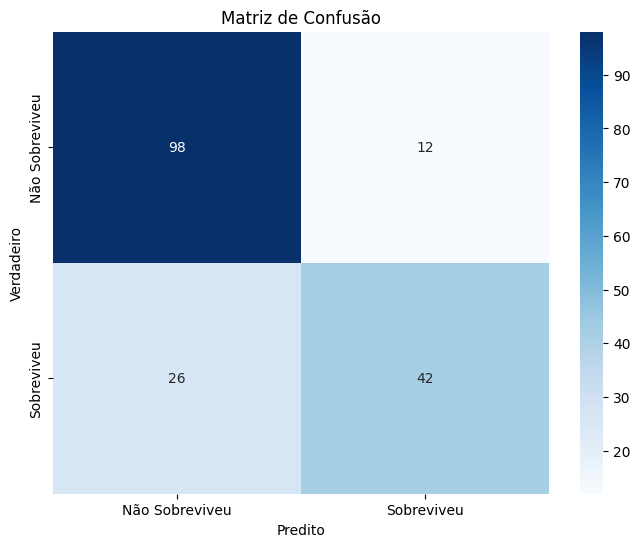


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.78      0.62      0.69        68

    accuracy                           0.79       178
   macro avg       0.78      0.75      0.76       178
weighted avg       0.79      0.79      0.78       178



In [150]:
y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype("int32") # Converter probabilidades para classes (0 ou 1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_val, y_pred)

# Visualizar a matriz de confusão com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Apresentar outras métricas importantes (precisão, recall, F1-score)
print("\n--- Relatório de Classificação ---")
print(classification_report(y_val, y_pred))

## Generate Evaluation Submission

In [151]:
y_pred_proba = model.predict(test_df)
y_pred = (y_pred_proba > 0.5).astype("int32") # Converter probabilidades para classes (0 ou 1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [152]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    

In [153]:
test_raw_df = pd.read_csv('test.csv')
submission_df = pd.DataFrame({'PassengerId': test_raw_df['PassengerId'], 'Survived': y_pred.flatten()})

In [154]:
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [155]:
submission_df.to_csv('submission.csv', index=False)

![](./kaggle.png)